In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(irlba)
library(umap)
library(data.table)
library(cowplot)
library(Matrix)
library(BuenColors)
library(scales)
library(SummarizedExperiment)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: MASS
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, 

### Preprocess

In [2]:
df_count = readRDS('../../input/bonemarrow_noisy_p2.rds')

df_sample = read.table('../../input/metadata.tsv',stringsAsFactors = FALSE)

df_region = data.frame(do.call(rbind,strsplit(rownames(df_count),'_')),stringsAsFactors = FALSE)
colnames(df_region) <- c("chr", "start", "end")
df_region$start = as.integer(df_region$start)
df_region$end = as.integer(df_region$end)

gr_region = makeGRangesFromDataFrame(df_region, keep.extra.columns = TRUE)

In [3]:
# Make RangedSummarizedExperiment
se <- SummarizedExperiment(
  rowRanges = gr_region,
  colData = df_sample,
  assays = list(counts = df_count)
)

In [4]:
se

class: RangedSummarizedExperiment 
dim: 156311 1200 
metadata(0):
assays(1): counts
rownames(156311): chr1_9942_10442 chr1_11036_11536 ...
  chrX_155258908_155259408 chrX_155259892_155260392
rowData names(0):
colnames(1200): CD4_1 CD4_2 ... NK_1199 NK_1200
colData names(1): label

In [5]:
run_pca <- function(mat,num_pcs=50,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    SVD_vd = t(sk_diag %*% t(SVD$v))
    return(t(SVD_vd))
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap1','umap2','celltype')
    df_umap$umap1 = as.numeric(df_umap$umap1)
    df_umap$umap2 = as.numeric(df_umap$umap2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap1, y = umap2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

run_control <- function(datafr,num_pcs=10){
    mat = as.matrix(datafr)
    fm_control = run_pca(mat,num_pcs = num_pcs)
    return(fm_control)
}

### Analysis

In [6]:
workdir = './peaks_frequency_results/'
path_umap = paste0(workdir,'umap_rds/')
path_fm = paste0(workdir,'feature_matrices/')
system(paste0('mkdir -p ',path_umap))
system(paste0('mkdir -p ',path_fm))

In [8]:
datafr = assays(se)$counts

In [9]:
dim(datafr)

[1] 156311   1200

In [10]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [11]:
n_cells_peak = Matrix::rowSums(as.matrix(datafr > 0) + 0)
df_n_cells_peak = data.frame(n_cells = n_cells_peak)

In [12]:
list_cutoff = c(1.0,0.80,0.60,0.40,0.20,0.10,0.08,0.06,0.04,0.02,0.01)

In [13]:
indices_sorted = order(n_cells_peak,decreasing = TRUE)

In [14]:
head(n_cells_peak[indices_sorted])

chr4_166248422_166248922  chr5_151151149_151151649  chr8_110346193_110346693 
                      557                       526                       491 
 chr5_108084306_108084806 chr11_105947953_105948453    chr8_74884351_74884851 
                      478                       473                       462

In [15]:
options(repr.plot.width=3, repr.plot.height=3)
list_hist_plots = lapply(list_cutoff, function(x)
           ggplot(log10(df_n_cells_peak+1), aes(x=n_cells)) + labs(y='frequency')+
    geom_histogram(color="black", fill="white",bins = 50) + 
    geom_vline(aes(xintercept=log10(n_cells_peak[indices_sorted[round(length(n_cells_peak)*x)]]+1)),
                color="indianred", linetype="dashed", size=1))
names(list_hist_plots) = as.character(list_cutoff)

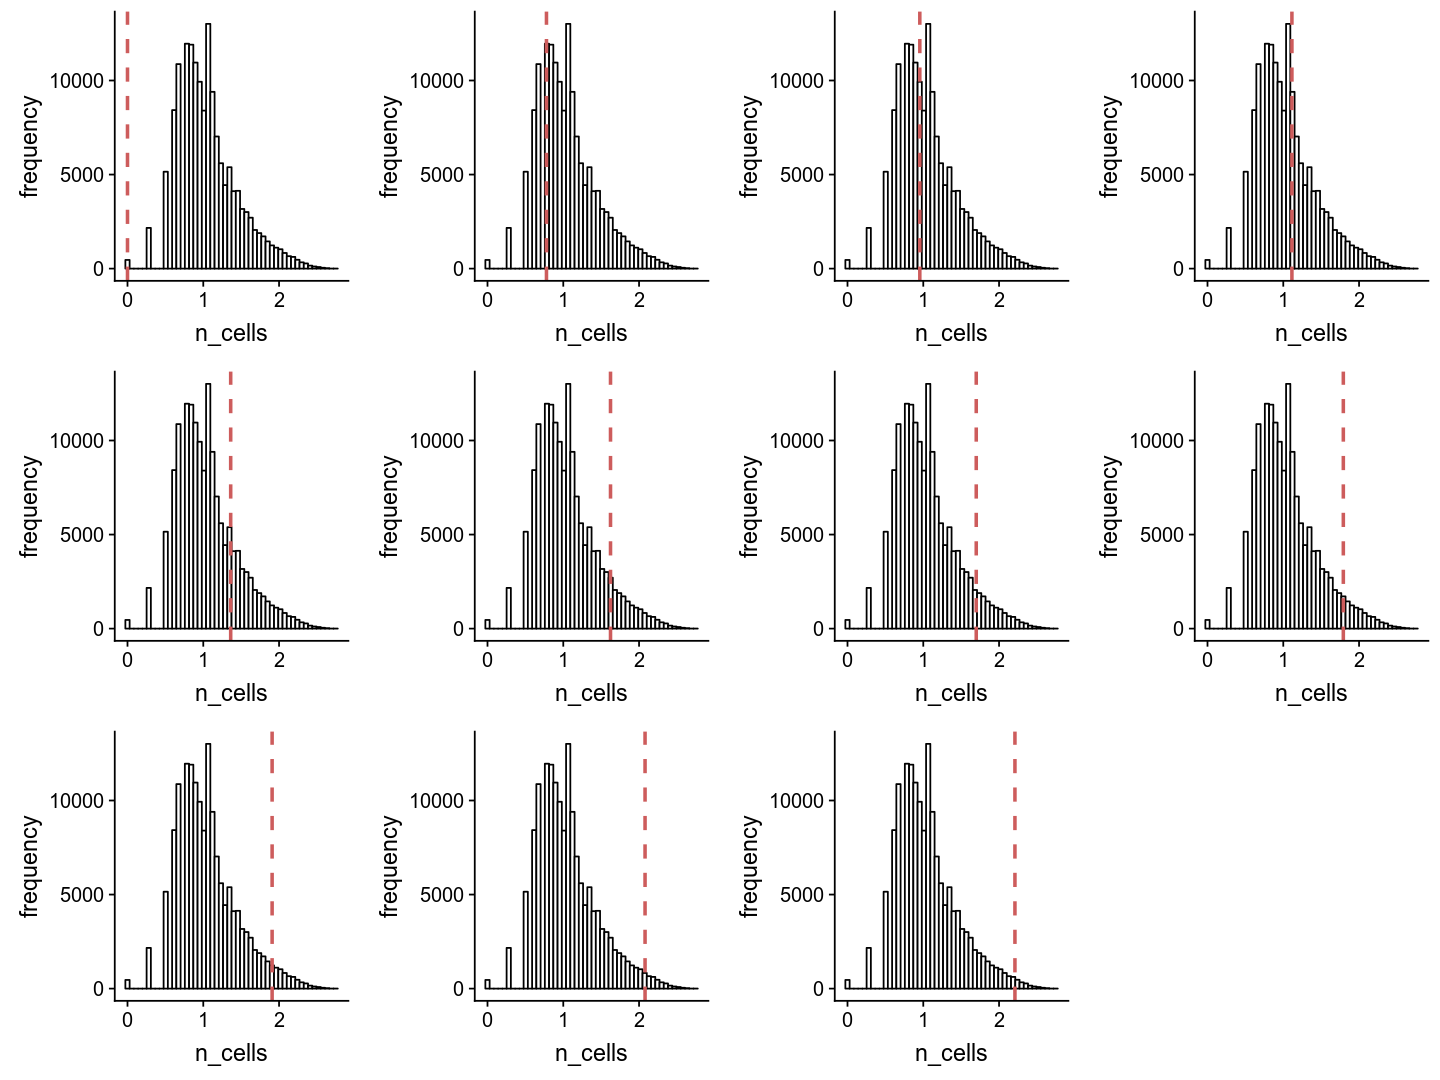

In [17]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_hist_plots, ncol = 4)

In [18]:
labels = se@colData$label
colormap = jdb_color_maps

In [19]:
list_elbow_plots <- c()
list_umap_plots <- c()
list_n_peaks <- c()
list_fm <- c()
list_umap <- c()
for(cutoff in list_cutoff){
    datafr_sub = datafr[sort(indices_sorted[1:round(length(n_cells_peak)*cutoff)]),] 
    mat_control = datafr_sub

    list_n_peaks[[as.character(cutoff)]] <- dim(mat_control)[1]
    print(dim(mat_control))

    p_elbow_control <- elbow_plot(mat_control,num_pcs = 20, title = 'PCA on control')
    list_elbow_plots[[as.character(cutoff)]] = p_elbow_control
    
    fm_control = run_control(mat_control,num_pcs=10)
    list_fm[[as.character(cutoff)]] = fm_control
    
    df_umap_control <- run_umap(fm_control)
    list_umap[[as.character(cutoff)]] = df_umap_control
    
    p_control <- plot_umap(df_umap_control,labels = labels,colormap = colormap,
                                  title=paste0('control \n(Top ',as.character(percent(cutoff)),', ',
                                                as.character(dim(mat_control)[1]),'peaks)'))
    p_control <-  p_control+theme(legend.position = "none")
    list_umap_plots[[as.character(cutoff)]] = p_control
}

[1] 156311   1200
[1] 125049   1200
[1] 93787  1200
[1] 62524  1200
[1] 31262  1200
[1] 15631  1200
[1] 12505  1200
[1] 9379 1200
[1] 6252 1200
[1] 3126 1200
[1] 1563 1200


In [20]:
for(x in list_cutoff){
    char_cutoff = as.character(x)
    fm_mat = data.frame(list_fm[char_cutoff])
    colnames(fm_mat)=colnames(datafr)
    rownames(fm_mat)=paste0('PC',seq(dim(fm_mat)[1]))
    df_umap = data.frame(list_umap[char_cutoff])
    rownames(df_umap)=colnames(datafr)
    saveRDS(fm_mat,paste0(path_fm,'FM_control',char_cutoff,'.rds'))
    saveRDS(df_umap,paste0(path_umap, paste0('df_umap_',char_cutoff,'.rds')))
}

In [21]:
save.image(file = 'Control_peaks_frequency.RData')

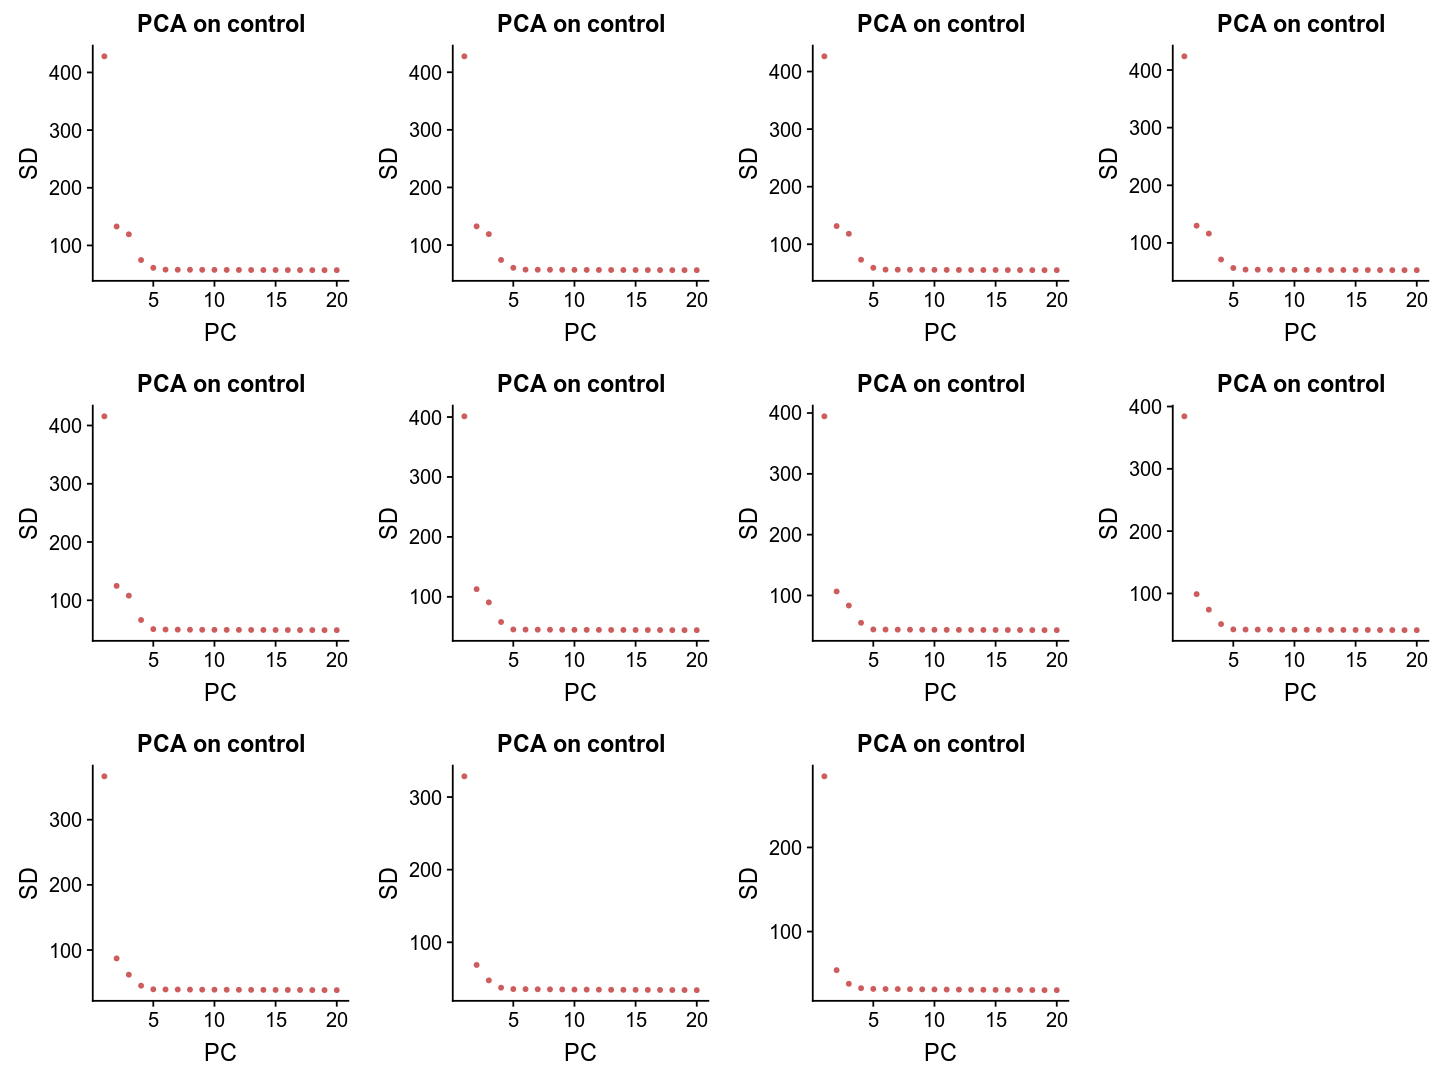

In [22]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_elbow_plots, ncol = 4)

In [23]:
list_n_peaks

1    0.8    0.6    0.4    0.2    0.1   0.08   0.06   0.04   0.02   0.01 
156311 125049  93787  62524  31262  15631  12505   9379   6252   3126   1563

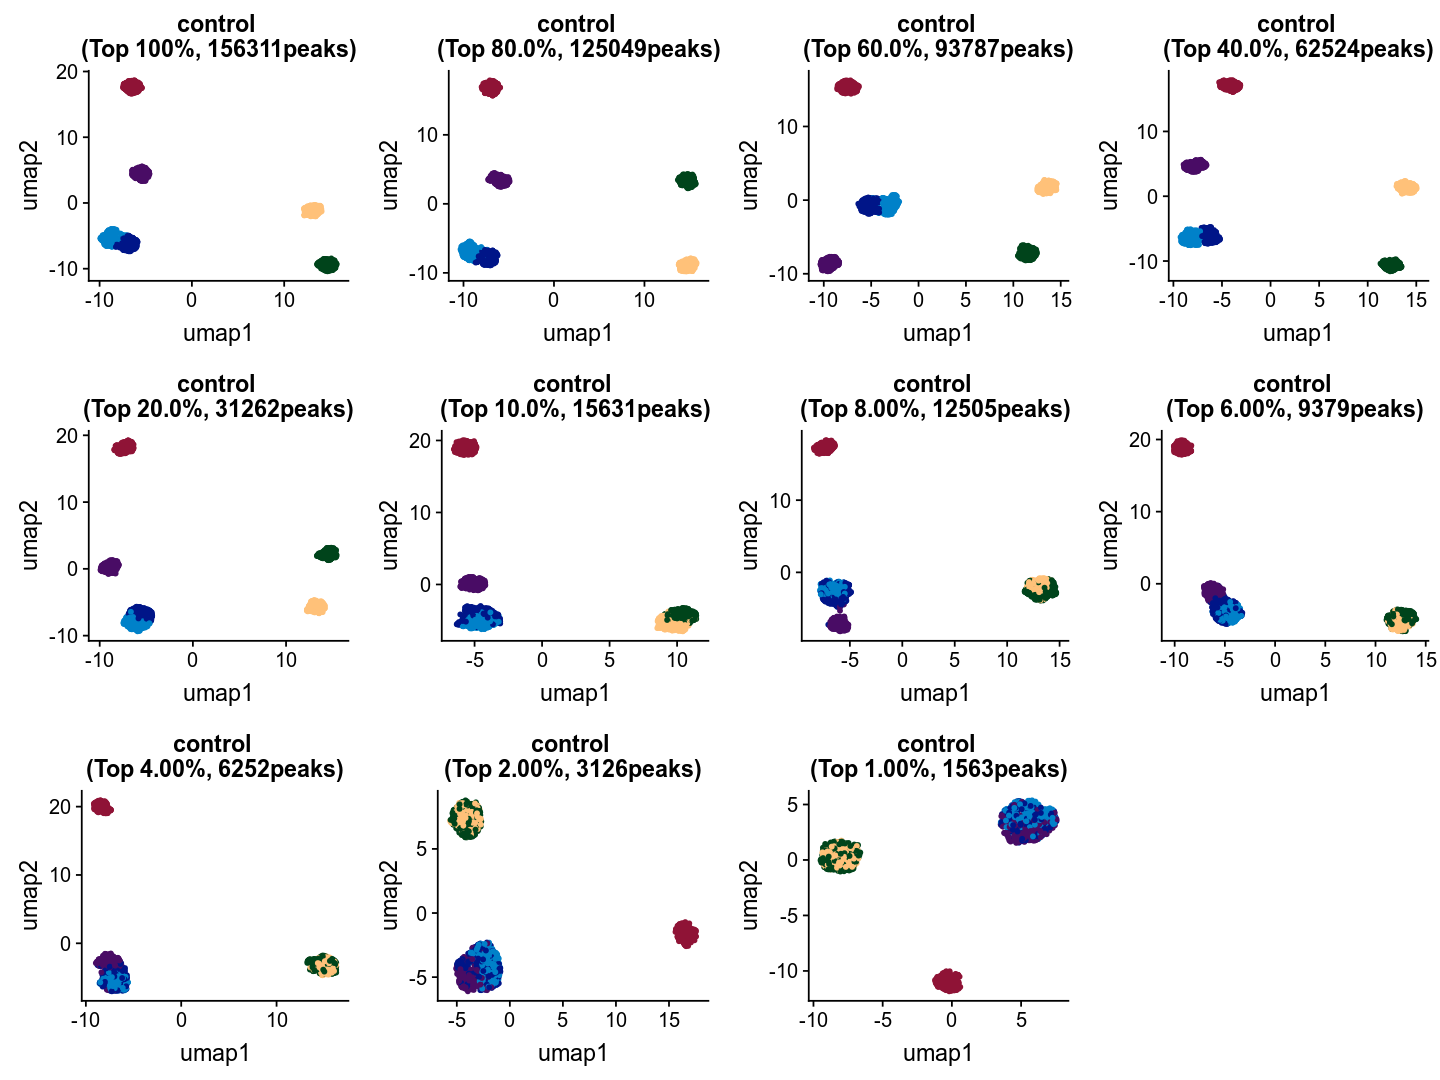

In [24]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_umap_plots, ncol = 4)

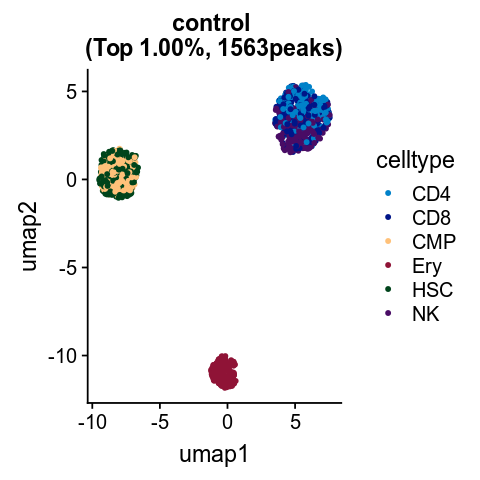

In [25]:
p_latest = plot_umap(df_umap_control,labels = labels,colormap = colormap,
                                  title=paste0('control \n(Top ',as.character(percent(cutoff)),', ',
                                                as.character(dim(mat_control)[1]),'peaks)'))
p_latest

In [26]:
library(ggpubr)

Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:cowplot’:

    get_legend



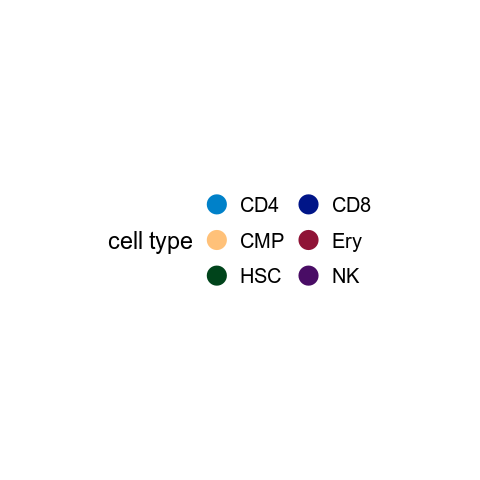

In [27]:
options(repr.plot.width=4, repr.plot.height=4)
leg <- cowplot::get_legend(p_latest + theme(legend.direction = "horizontal", legend.position = c(0.2,0.5)) + 
                           labs(color='cell type')+
                           guides(color=guide_legend(nrow=3,byrow=TRUE,override.aes = list(size=5))))

p_legend = as_ggplot(leg)
p_legend

In [28]:
list_umap_plots2 <- list_umap_plots
list_umap_plots2 <- append(list_umap_plots2, list('legend'=p_legend), 0)

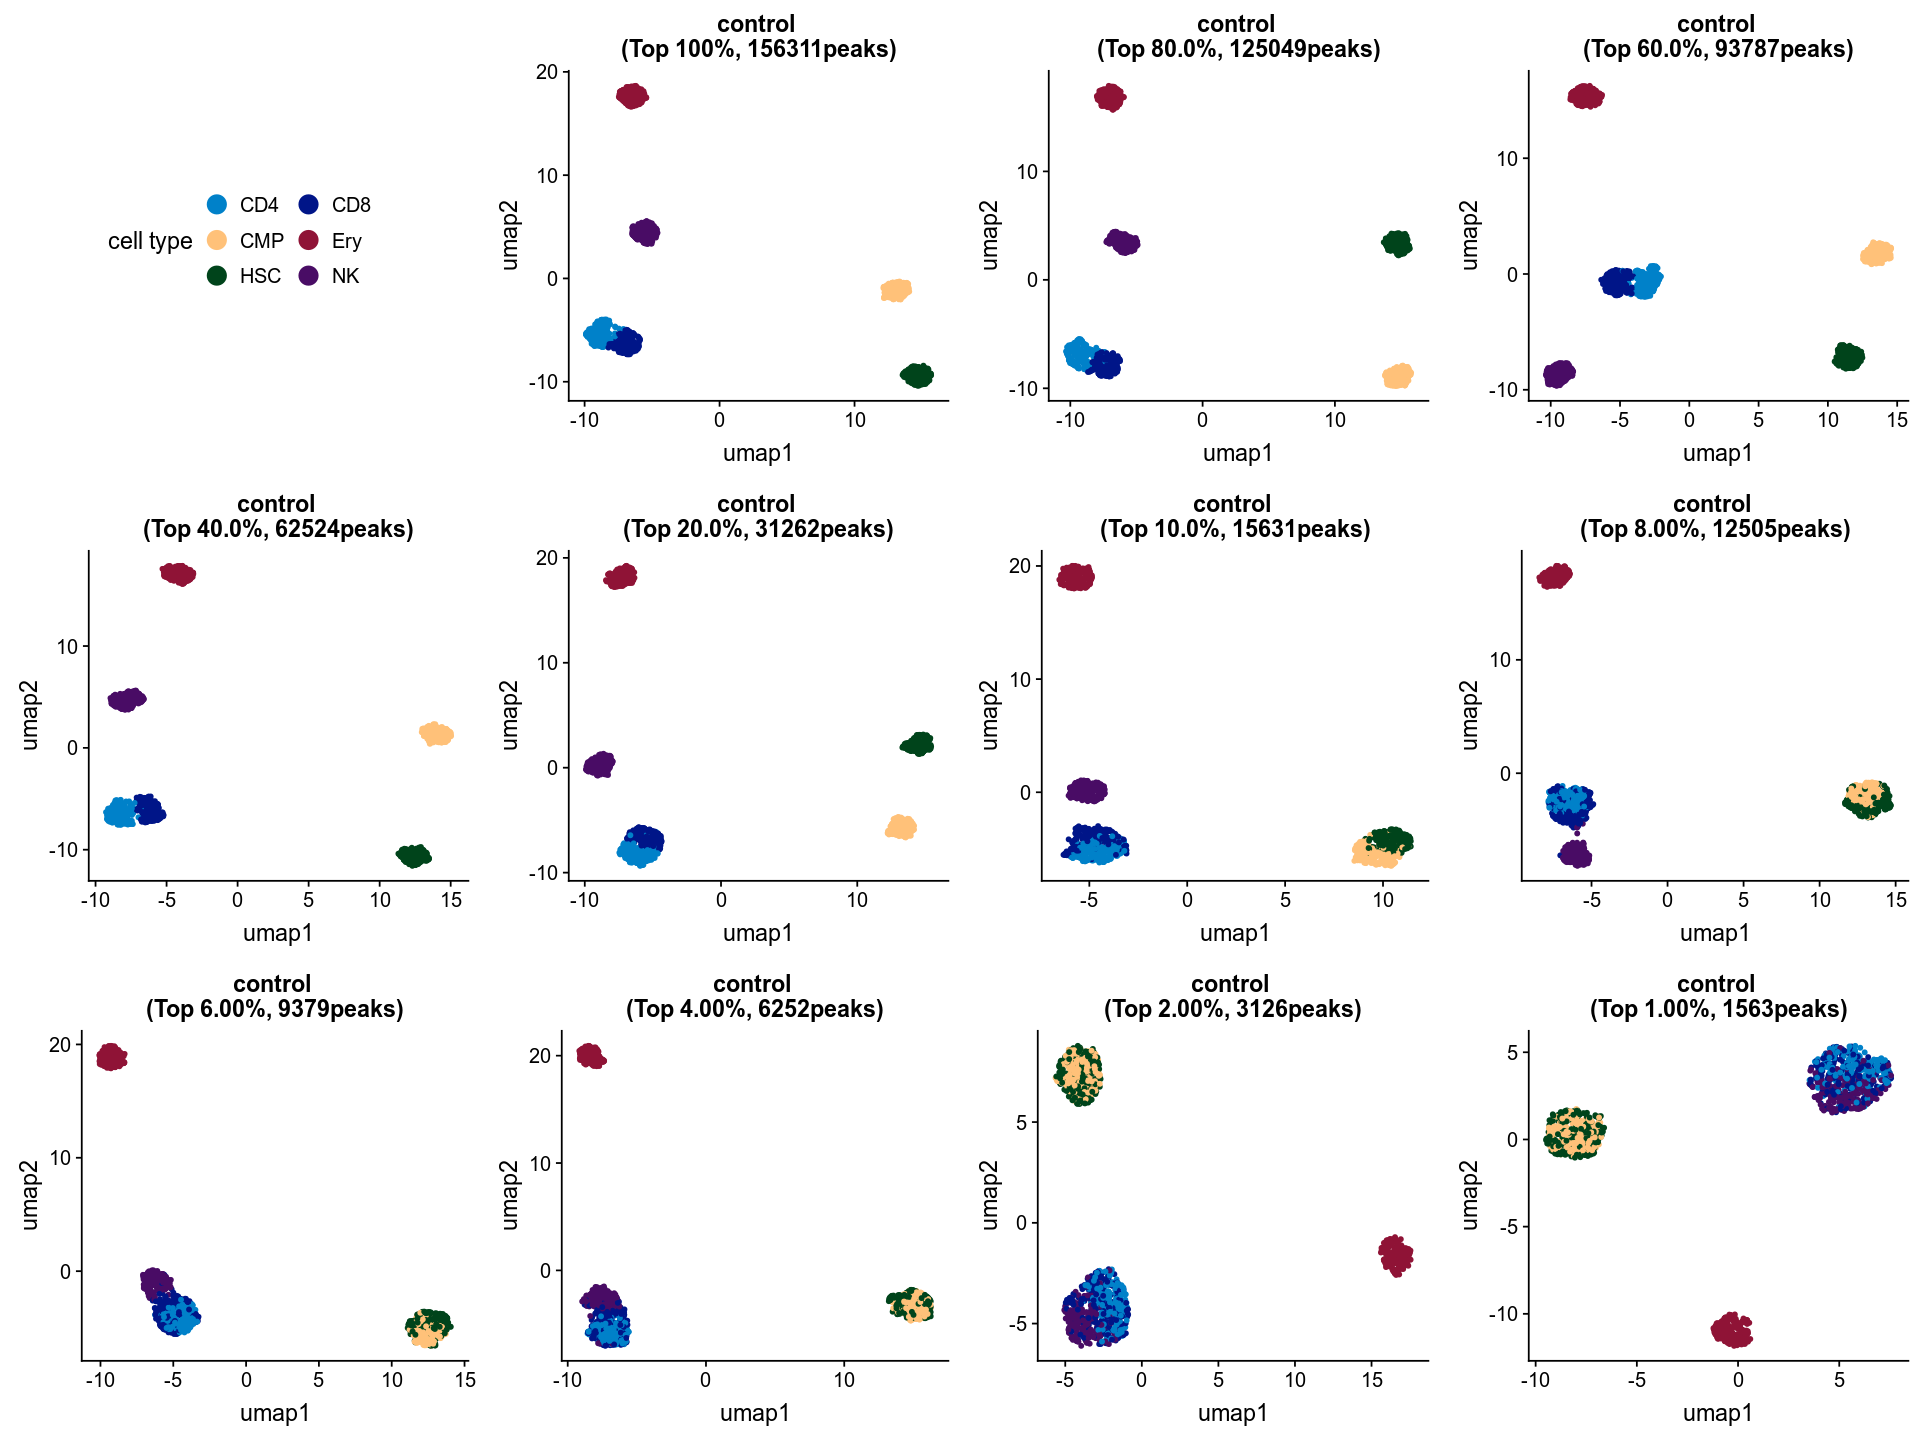

In [29]:
options(repr.plot.width=4*4, repr.plot.height=4*3)
p_group = cowplot::plot_grid(plotlist = list_umap_plots2, ncol = 4)
p_group

In [30]:
cowplot::ggsave(p_group,filename = 'Control_peaks_frequency.pdf', width = 4*4, height = 4*3)